# COVID screening lab simulation

This version of the simulation is based on the following process description, with the option to adjust the batch size of the hat stage, e.g. 93 or 372 tubes as on one process step).

<img src="figs/process_9.png">

## Requirements and module imports

Code in this simulation uses a standard Anaconda Python environment (https://www.anaconda.com/distribution/#download-section). Additionally this model uses SimPy3 (https://simpy.readthedocs.io/en/latest/). Install SimPy3 with `pip install 'simpy<4'`.

In [1]:
import simpy
import inspect
from sim_utils.replication import Replicator
from sim_utils.parameters import Scenario

## Set up scenarios

Parameters defined in scenarios will overwrite default values in the parameters python file.

In [2]:
# Set up a dictionary to hold scenarios
scenarios = {}

# Baseline sceanrio (model defaults)
scenarios['base'] = Scenario(
    
    samples_per_day = 30132,
    run_days = 2,
    warm_up_days = 2,
    
    # List of delivery times (hours from start of day)
    delivery_times = [0]
)



## Run model

                                                                               
Output results
--------------
                                     min          mean    median       max
                                  Result        Result    Result    Result
result_type               name                                            
demand_met                base      0.00      0.600000      0.67      0.69
input                     base  30132.00  30132.000000  30132.00  30132.00
max_process_time_hours    base     14.72     38.873333     41.05     41.93
median_process_time_hours base     14.72     27.932963     29.00     29.71
output                    base      0.00  18073.000000  20181.00  20832.00



Resources used
--------------
                             Available       Used  Utilisation
resource               name                                   
beckman_rna_extraction base         28  10.577465     0.377767
human_pcr_1            base         35   8.050000     0.230000
human

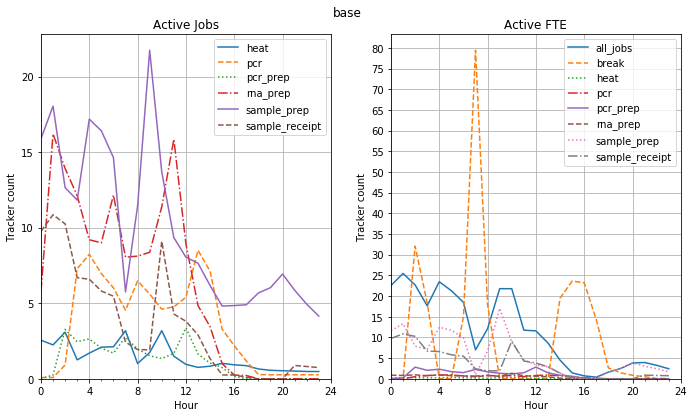

In [3]:
replications = 30
replications = Replicator(scenarios, replications)
replications.run_scenarios()

## Show model default parameters

Run the code below to model defaults these are over-ridden by scenarios).

In [4]:
print(inspect.getsource(Scenario.__init__))

    def __init__(self, *initial_data, **kwargs):
        
        # Set default values
        # 16/4/2020 Adjust paramters so that day starts with FTE arrival


        # Work arrival
        self.samples_per_day = 30132
        # List of sample arrival times (from start of day)
        self.delivery_times = [0]
        self.basic_batch_size = 93

        # Day and run parameters
        # 16/4/2020 Model is designed to run primarily in single days
        self.day_duration = 1440
        self.run_days = 1
        self.warm_up_days = 0
        
        # Breaks for people (high priority job, but does not interrupt work)
        # Times from start of FTE day (6am)
        self.tea_break_times = [2*60, 16*60]
        self.meal_break_times = [6.5*60, 14*60]
        # Spread start of break for people randomly after set start times
        self.break_start_spread = 60
                
        # break duration is a uniform distribution between min and max
        self.tea_break_duration = [